# Performing Drug Discovery with GNNs

In [ ]:
#@title Run this cell first. You will notice that your Colab session will crash and restart. This is intended behavior. Once your session restarts, do NOT re-run this cell. Instead, run the next cell and continue from there.

!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/jaimergp/miniforge/releases/latest/download/Mambaforge-colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:38
🔁 Restarting kernel...


In [ ]:
#@title Run this to download our data and set up packages while you discuss the intro below!
!mamba install -c conda-forge rdkit

!pip install --pre deepchem
import deepchem

!wget https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/Deep%20Dives/AI%20%2B%20Healthcare/Sessions%201-5/Drug%20Discovery%20with%20GNNs/delaney-processed.csv
!wget https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/Deep%20Dives/AI%20%2B%20Healthcare/Sessions%201-5/Drug%20Discovery%20with%20GNNs/tox21.csv.gz

import gzip
import shutil
with gzip.open('tox21.csv.gz', 'rb') as f_in:
    with open('tox21.csv', 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)


from deepchem.utils.save import load_from_disk

# Data Structures
import numpy as np
import pandas as pd

# Graphing
import matplotlib.pyplot as plt

# Metrics
from sklearn.model_selection import train_test_split
from sklearn import metrics

# ML Models
from deepchem.models import GraphConvModel
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier

Streaming output truncated to the last 5000 lines.
libwebp                  [] (00m:00s) Waiting...
libopenblas              [] (00m:00s)      8 MB /      9 MB (  5.67 MB/s)
numpy                    [] (00m:00s) Waiting...
pillow                   [] (00m:00s) Waiting...
rdkit                    [] (00m:00s)      4 MB /     38 MB (  2.89 MB/s)
xorg-libice              [] (00m:00s) Waiting...
xorg-xextproto           [] (00m:00s) Waiting...
cycler                   [] (00m:00s) Waiting...
libblas                  [] (00m:00s) Waiting...
greenlet                 [] (00m:00s) Waiting...
libtiff                  [] (00m:00s) Waiting...
python-dateutil          [] (00m:00s) Waiting...
pandas                   [] (00m:00s)    650 KB /     13 MB (466.64 KB/s)
typing_extensions        [] (00m:00s) Validating...
xorg-libxrender          [] (00m:00s) 
libpng                   [] (00m:01s) Decompressing...
boost-cpp                [] (00m:01s) Validating...
libgfortran5             [] (00m:01s) W

deepchem.utils.save has been deprecated.
The utilities in save.py are moved to deepchem.utils.data_utils or deepchem.utils.genomics_utils.


Each year, the FDA approves 40 - 50 new drugs, targeting a variety of illnesses and diseases!

But how successful and cost-effective is the process?

![alt text](https://www.researchgate.net/profile/Niroshini-Nirmalan/publication/308045230/figure/fig1/AS:613907634872358@1523378394724/Drug-discovery-and-development-timeline-The-current-drug-approval-pipeline-can-take-15.png)

**Question:** What are some causes of difficulties in the drug discovery process? Why does it take so long? Why might a drug fail?


In [ ]:
Answer = "A drug might fail because it could lead to unexpected side effects or scientists could not know how much of a drug to give someone." #@param {type:"string"}

Let's take a closer look at a few key components of the drug discovery process. 

**Key component 1**: Identifying a *target* for which to design a drug. 

**Question:** What are some examples of drug targets? 

In [ ]:
Answer = "A virus, diseases, and certain bacteria" #@param {type:"string"}

**Key component 2**: Thousands of potential drugs must be tested to determine their effect on the target. 

**Question:** What could be done to make this process of brute-force testing potential drugs more efficient?

In [ ]:
Answer = "AI could be used to do the brute-forcing process in order to make the process faster. If after a few iterations we see consistent bad affects, instead of using it over every possible iteration just stop it." #@param {type:"string"}

**Key component 3**: Promising drug candidates are then tested in animals and then humans. Human trials take place in 3 phases to test for both safety and efficacy. 

**Question:** Which stage(s) of the drug discovery process could be made more efficient with ML? Why? 



In [ ]:
Answer = "ML can be used to recognize un-discovered diseases and also be used to discover what proteins might work" #@param {type:"string"}

Nice! Now, that we've explored the drug development pipeline, let's try to build an ML model for drug discovery ourselves. Using a specialized scientific library called `deepchem`, we'll explore two stages of the drug discovery process to see how AI can help us screen drug candidates! We will:
*   Predict solubility using linear regression and graph neural networks
*   Predict toxicity using graph neural networks
*   See what portion of molecules get through our screenings!



# Determining Molecular Solubility

One of the biggest early challenges in drug discovery is to find drugs that will be [absorbed by the human body](https://www.technologynetworks.com/drug-discovery/articles/what-is-adme-336683).

In this notebook, we'll start by predicting the **solubility** of various drug candidates: **how much of the drug can dissolve in water**. We need to find soluble molecules which can circulate through the bloodstream!

For this task, we'll use the `deepchem` and `rdkit` libraries. We'll also explore multiple ML models including graph neural networks (GNNs).



Now, let's take a look at what the first 5 rows of `delaney-processed.csv` look like! This is the file with our solubility information. 

In [ ]:
solubility_data = pd.read_csv("delaney-processed.csv")

# TODO: Print out first five rows and dataset size
solubility_data.head()

,Compound ID,ESOL predicted log solubility in mols per litre,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre,smiles
0,Amigdalin,-0.974,1,457.432,7,3,7,202.32,-0.77,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...
1,Fenfuram,-2.885,1,201.225,1,2,2,42.24,-3.30,Cc1occc1C(=O)Nc2ccccc2
2,citral,-2.579,1,152.237,0,0,4,17.07,-2.06,CC(C)=CCCC(C)=CC(=O)
3,Picene,-6.618,2,278.354,0,5,0,0.00,-7.87,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43
4,Thiophene,-2.232,2,84.143,0,1,0,0.00,-1.33,c1ccsc1


Cool! Look's like we've got quite a few columns in our data matrix. What does each one represent?

Here are some of the most important ones:

*   **Compound ID**: The chemical compound name
*   **ESOL predicted log solubility in mols per litre**: The predicted solubility for each compound using a standard method, ESOL. This represents the ability of a compound to dissolve in a non-polar solvent (oils, lipids).
*   **measured log solubility in mols per litre**: The measured solubility for each compound. This is what we're trying to predict!
*   **smiles**: The string notation representation for each compound's molecular structure.

**Optional**: If you're interested in the chemistry, read on:
*   **Minimum Degree**: The minimum number of bonds to any atom in the compound.
*   **Molecular Weight**: The molar mass of the compount in g/mol.
*   **Number of H- Bond Donors**: The number of hydrogen atoms in the molecule that are "donated" to form hydrogen bonds.
*   **Number of Rotatable Bonds**: The number of bonds that are connected to "non-terminal heavy atoms" that aren't part of a ring. 
*   **Polar Surface Area**: The total surface area of the polar atoms and molecules. Examples of polar molecules are are water and ammonia.
*   **Number of Rings**: The number of rings present on the molecular diagram. For example, Amigdalin has 3 rings, as shown in this image:

![alt text](https://file.medchemexpress.com/product_pic/hy-n0190.gif)


##Baseline: Predicting Solubility with Linear Regression
Now, let's determine how we can begin predicting solubility! 

We'll start with linear regression as a baseline to compare to GNN. Which columns would represent our `X` (raw data) and `y` (output) variables?

In [ ]:
input_cols = ["Minimum Degree", "Polar Surface Area",  "Molecular Weight", "Number of H-Bond Donors", "Number of Rings", "Number of Rotatable Bonds"] # TODO: [ FILL IN INPUTS ]
output_cols = ["measured log solubility in mols per litre"] # TODO: [ FILL IN OUTPUT ]

X = solubility_data[input_cols]
y = solubility_data[output_cols]

Now, let's perform a test/train split with 20% testing data, **without shuffling**:

In [ ]:
# TODO: Use train_test_split to split the data with 20% testing data
x_train, x_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

Now, let's initialize and train a linear regression model.

In [ ]:
import sklearn
from sklearn import linear_model

lm = sklearn.linear_model.LinearRegression()

# TODO: Fit the model 
lm.fit(x_train, y_train)

LinearRegression()

To calculate our peformance we'll use the R^2 metric and the function `metrics.r2_score`. We've used this metric to evaluate our previous linear regression models! An R^2 value is within the range of 0 to 1, and greater values are better.

In [ ]:
#YOUR CODE HERE to score linear regression on the test set
y_pred = lm.predict(x_test)
metrics.r2_score(y_test, y_pred)

0.6024918982930053

How good does this prediction seem?

R^2 can be a little hard to interpret, so let's look at a plot:

Text(0, 0.5, 'Predicted Log Solubility')

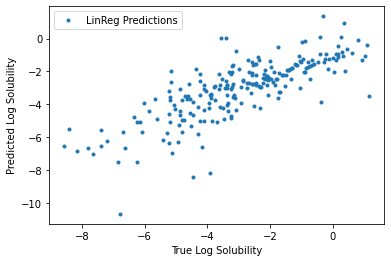

In [ ]:
plt.plot(y_test, y_pred, '.')
plt.legend(['LinReg Predictions'])
plt.xlabel("True Log Solubility")
plt.ylabel("Predicted Log Solubility")

###Optional Exercise: Comparing with ESOL

You might be wondering about the ESOL predictions in our dataset - those actually also come from a [linear regression model](https://pubs.acs.org/doi/abs/10.1021/ci034243x) trained on a bigger dataset! What features do they use? How do their predictions compare to ours?

Let's select the ESOL predictions on our test set:

In [ ]:
esol_pred = solubility_data['ESOL predicted log solubility in mols per litre'].loc[y_test.index]

Now, can you output the R^2 and graph as before? Does it beat our linear regression model?

Researchers have ESOL at their disposal, so that's the tool we'd want to beat!

In [ ]:
#YOUR CODE HERE
metrics.r2_score(y_test, esol_pred)

0.7839834529021221

#Graph Neural Networks

So far, we've made our predictions using molecules' chemical properties. But using GNNs, we can directly use the molecules' structure, by representing each molecule as a **graph** of nodes and connections. Let's see if we get better results!

![alt text](https://snappygoat.com/b/a59dd47ded9e6b82231b2cbe1af91e56c8e0e291)

**Question**: How many nodes and connections are there in this molecule of Methane (CH4)?

In [ ]:
Answer = "5 nodes, 4 connections" #@param {type:"string"}

We'll get the molecules structure from the "smiles" column. 

Let's load and split our dataset using the `deepchem` data format (not a nice human-readable table - we'll explore it below!)

In [ ]:
#What do tasks, feature_field, and featurizer mean?
loader = deepchem.data.CSVLoader(tasks=["measured log solubility in mols per litre"], 
                                 feature_field="smiles", 
                                 featurizer=deepchem.feat.ConvMolFeaturizer())
solubility_smiles_data = loader.create_dataset("delaney-processed.csv")

splitter = deepchem.splits.IndexSplitter()
sol_train_dataset, sol_test_dataset = splitter.train_test_split(solubility_smiles_data,
                                                                 frac_train=0.8)

Now we've defined our training and testing datasets! (Both `X` and `y` are stored in the dataset variable, and the order is the same as before).

Finally, we can **define and train our model** using `sol_gnn = GraphConvModel()`. You'll need to decide:


*   How many tasks (different output columns we're predicting)?
*   Classification or regression?
*   Should we use dropout? (Recommended: 0.2).
*   How many epochs to train for? (Try 600 or 2000).

Of course, you can experiment with the dropout and number of epochs!


In [ ]:
import warnings
warnings.filterwarnings('ignore')

#YOUR CODE HERE
sol_gnn = GraphConvModel(n_tasks=1, mode="regression", dropout=0.2)
sol_gnn.fit(sol_train_dataset, nb_epoch=600)

0.11739109992980958

The number printed above is the most recent loss. 

Now, **let's evaluate our model's performance on the test set using R^2 and a graph**! How does it compare to our linear model and ESOL?

(Remember that ESOL is trained on a larger dataset, and it's often used by professionals!)

0.6024918982930053
0.7839834529021221
0.6978684764994783


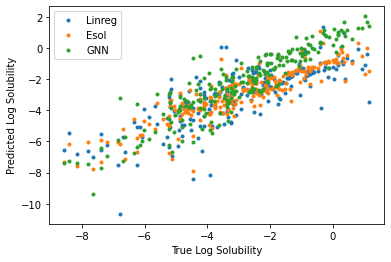

In [ ]:
gnn_pred = sol_gnn.predict(sol_test_dataset) #YOUR CODE HERE to predict on the test set

#YOUR CODE HERE to evaluate our model
print(metrics.r2_score(y_test, y_pred))
print(metrics.r2_score(y_test, esol_pred))
print(metrics.r2_score(y_test, gnn_pred))

plt.plot(y_test, y_pred, '.')
plt.plot(y_test, esol_pred, '.')
plt.plot(y_test, gnn_pred, '.')
plt.xlabel("True Log Solubility")
plt.ylabel("Predicted Log Solubility")
plt.legend(["Linreg", "Esol", "GNN"])

Now we have a pretty good estimated solubility for each molecule! How can we use that to choose promising drug candidates?

As a very rough estimate, we can consider a molecule **soluble** if its log solubility (moles/liter) is greater than 0. **According to our GNN model, what percent of drugs in our test set are soluble**? How many drug candidates can we move forward?

In [ ]:
gnn_pred_series = pd.Series(gnn_pred.squeeze(), index = y_test.index)

#YOUR CODE HERE to print out % of soluble molecules
soluble = gnn_pred_series[gnn_pred_series>0]
#Optional Challenge: show the molecules that are predicted soluble!
print(len(soluble)/len(gnn_pred_series))
print(soluble)
solubility_data.loc[soluble.index]

0.1415929203539823
903     0.781081
909     0.971834
919     1.153924
932     1.214693
937     0.026390
940     1.188860
953     0.137498
954     0.790392
974     0.692016
983     1.711172
991     0.332020
992     0.854758
998     0.824051
999     0.199850
1000    0.906155
1006    1.159441
1007    1.050920
1020    0.801653
1025    1.274182
1026    1.679922
1029    0.619775
1043    0.607821
1064    1.451288
1066    0.229515
1073    0.590403
1081    1.061507
1082    1.261737
1099    0.745569
1100    2.049412
1103    0.288665
1105    0.309436
1115    0.388115
dtype: float32


,Compound ID,ESOL predicted log solubility in mols per litre,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre,smiles
903,Ethyl propionate,-1.191,1,102.133,0,0,2,26.30,-0.660,CCOC(=O)CC
909,2-cyanoguanidine,0.361,1,84.082,2,0,0,88.19,-0.310,NC(N)=NC#N
919,Methyl acetate,-0.416,1,74.079,0,0,0,26.30,0.460,COC(=O)C
932,Pteridine,-0.906,2,132.126,0,2,0,51.56,0.020,c2cnc1ncncc1n2
937,3-Methyl-2-pentanone,-1.266,1,100.161,0,0,2,17.07,-0.670,CCC(C)C(=O)C
940,Nitromethane,-0.042,1,61.040,0,0,0,43.14,0.260,CN(=O)=O
953,Ethyne,-0.252,1,26.038,0,0,0,0.00,0.290,C#C
954,"3,5-Dimethylpyridine",-2.098,1,107.156,0,1,0,12.89,0.380,Cc1cncc(C)c1
974,3-Methyl-2-butanone,-0.912,1,86.134,0,0,1,17.07,-0.120,CC(C)C(=O)C
983,Ethanol,0.020,1,46.069,1,0,0,20.23,1.100,CCO


We can only move forward a small portion of our candidates! And this is just one early stage in the drug discovery pipeline...

##Optional: Exploring Deepchem formats

You might be curious about how our molecules are represented within the `Dataset` objects! Let's check it out. 

Try printing `sol_train_dataset`, `sol_train_dataset.X`, and `sol_train_dataset.X[0]`. What does each represent?

In [ ]:
#YOUR CODE HERE
print(sol_train_dataset)
print(sol_train_dataset.X)
print(sol_train_dataset.X[0])

<DiskDataset X.shape: (902,), y.shape: (902, 1), w.shape: (902, 1), ids: ['OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)C(O)C3O '
 'Cc1occc1C(=O)Nc2ccccc2' 'CC(C)=CCCC(C)=CC(=O)' ...
 'ClC1C=CC2C1C3(Cl)C(=C(Cl)C2(Cl)C3(Cl)Cl)Cl'
 'CCC(C)C1(CC(Br)=C)C(=O)NC(=O)NC1=O '
 'CC1(C)C(C(=O)OC(C#N)c2cccc(Oc3ccccc3)c2)C1(C)C'], task_names: ['measured log solubility in mols per litre']>


A ConvMol object represents a single molecule. There's lots of information we can pick out! Looking at the [source code](https://github.com/deepchem/deepchem/blob/master/deepchem/feat/mol_graphs.py#L46), what other information can you access?

In [ ]:
my_molecule = sol_train_dataset.X[0] #Choose any index you want!
print (my_molecule.n_atoms) #Number of atoms

#YOUR CODE HERE to print out other info
print(my_molecule.n_feat)
print(my_molecule.atom_features)

32
75
[[0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]


We can also see the molecule's numerical representation that's fed into the GNN: a vector for each atom. **Can you explain the shape of this array?**

In [ ]:
atom_features = my_molecule.get_atom_features()
print (atom_features)
print (atom_features.shape)

[[0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]
(32, 75)


#Optional (More Advanced): Determining Molecular Toxicity

Now we've narrowed down our drug candidates to soluble ones. Next up, let's look at an even more important metric: **toxicity**. We need to be sure that our drugs won't harm other biological systems in the body!

We'll use GNNs to predict toxicity from the SMILES representation. We'll use a different dataset here, stored in `tox21.csv`. Please load it in! What do you think each column means?


In [ ]:
# TODO: Read in the data file
toxicity_data = pd.read_csv("tox21.csv")
# TODO: View the first 5 rows
toxicity_data.head()

,NR-AR,NR-AR-LBD,NR-AhR,NR-Aromatase,NR-ER,NR-ER-LBD,NR-PPAR-gamma,SR-ARE,SR-ATAD5,SR-HSE,SR-MMP,SR-p53,mol_id,smiles
0,0.0,0.0,1.0,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,TOX3021,CCOc1ccc2nc(S(N)(=O)=O)sc2c1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0,TOX3020,CCN1C(=O)NC(c2ccccc2)C1=O
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,TOX3024,CC[C@]1(O)CC[C@H]2[C@@H]3CCC4=CCCC[C@@H]4[C@H]...
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0,TOX3027,CCCN(CC)C(CC)C(=O)Nc1c(C)cccc1C
4,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,TOX3028,CC(O)(P(=O)(O)O)P(=O)(O)O


**Each column represents a different type of assay, or experiment.** Those that start with NR are Nuclear Receptor Signaling Panels and those that start with SR are Stress Response Panels. You can read more about the data [here](https://tripod.nih.gov/tox21/challenge/data.jsp). 

Measuring these responses tells us whether the body is trying to fight off something it thinks is toxic. Each column shows a different toxicity indicator, so we'll train models for each! Each column is a different *task* to be learned. 

Let's load up our dataset!

In [ ]:
_, datasets, transformers = deepchem.molnet.load_tox21(featurizer='GraphConv')
tox_train_dataset, tox_valid_dataset, tox_test_dataset = datasets

Next, please **create a GNN model for toxicity and train it for 20 epochs** (much bigger dataset). There are a few differences this time! How many **tasks** are there? Are we doing **classification or regression**?

In [ ]:
import warnings
warnings.filterwarnings('ignore')

#YOUR CODE HERE to create and train your model
tox_gnn = GraphConvModel(n_tasks=12, mode="classification", dropout=0.2)
tox_gnn.fit(tox_train_dataset, nb_epoch = 20)

0.7262481689453125

###Evaluating our Model
Since we're doing twelve different classifications, evaluating our model is a little trickier. Let's get our raw predictions on the test data:



In [ ]:
tox_pred = tox_gnn.predict(tox_test_dataset)[:,:,1]
tox_pred

array([[0.07566098, 0.01826149, 0.17984919, ..., 0.29894704, 0.10479306,
        0.19424391],
       [0.2644246 , 0.14354962, 0.9095203 , ..., 0.9054035 , 0.9930795 ,
        0.9401566 ],
       [0.37622184, 0.03731401, 0.91408646, ..., 0.842728  , 0.9844803 ,
        0.4714652 ],
       ...,
       [0.2170905 , 0.05423328, 0.71059304, ..., 0.46187747, 0.82764375,
        0.3731161 ],
       [0.79836404, 0.56372267, 0.11950346, ..., 0.2790453 , 0.42445713,
        0.65121037],
       [0.5509496 , 0.14356643, 0.7216239 , ..., 0.06540638, 0.3152856 ,
        0.75465727]], dtype=float32)

**What's the shape of the array?** What does each number indicate?

Let's convert our raw predictions to a 0/1 classification:


In [ ]:
print(tox_pred.shape)
tox_pred_class = (tox_pred>.5) #YOUR CODE HERE

(784, 12)


Now, let's calculate out overall accuracy for all twelve tasks: what percent of predictions did we get right? 

Hints: You can get the true answers using `tox_test_dataset.y`. The `mean` method could be useful.

**What "baseline accuracy"** could we achieve by always guessing the same answer?

**What accuracy did we achieve?** 



In [ ]:
#YOUR CODE HERE to calculate accuracy
accuracy = (tox_pred_class==tox_test_dataset.y).mean()
print(accuracy)
print(1-tox_test_dataset.y.mean())

0.5299744897959183
0.929421768707483


**Is accuracy a good metric here?** As an extra challenge, try calculating [precision or recall](https://en.wikipedia.org/wiki/Precision_and_recall) - whichever is more relevant!


###Identifying Safe Drugs
For now, let's trust our model, and think back to the problem of drug discovery. **What percent of drugs in the test set** does our model consider safe?

In [ ]:
any_toxic = tox_pred_class.any(axis=1) # What does this show?
print (any_toxic.shape)

#YOUR CODE HERE to calculate % safe
print(1-any_toxic.mean())

(784,)
0.10076530612244894


Again, we're discarding most of our drug candidates!

Using your knowledge of probability, what percent of drugs do you estimate would pass through both our **toxicity screening** and our **solubility screening**? 

In [ ]:
#YOUR CODE HERE
print((len(soluble)/len(gnn_pred_series))*(1-any_toxic.mean()))


0.014267653964240557


For every twenty molecules we try, only one would get through these two screenings! And of course, these are only two of the many stages in drug discovery.

Using what you've seen today, **what promise do you think AI holds** in speeding up the drug discovery process?